# External Data for Zindi Flood Prediction Project

In [14]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import distance_transform_edt
import geocube
from geocube.api.core import make_geocube
import rasterio
from rasterio.enums import Resampling
import os 

## Gather Data

<table>
  <tr>
    <th>File</th>
    <th>Source</th>
  </tr>
  <tr>
    <td>WaterwaysOSM.json</td>
    <td>[MASDAP Waterways Data](http://www.masdap.mw/layers/osm:osm_waterareas)</td>
  </tr>
  <tr>
    <td>MWI_water_areas_dcw.shp</td>
    <td>[DIVA-GIS Inland Water Areas](http://www.diva-gis.org/Data)</td>
  </tr>
  <tr>
    <td>MWI_water_lines_dcw.shp</td>
    <td>[DIVA-GIS Inland Water Line Vectors](http://www.diva-gis.org/Data)</td>
  </tr>
  <tr>
    <td>soilmoisture.tiff</td>
        <td>[NASA Soil Moisture Data](https://developers.google.com/earth-engine/datasets/catalog/NASA_USDA_HSL_SMAP_soil_moisture)
        (Extracted directly from Google Earth Engine using web scripting interface)
        </td>
  </tr>
</table>

In [7]:
# Using GeoPandas, read vector data into GeoDataFrames
waterways = gpd.read_file('data/WaterwaysOSM.json')
wareas = gpd.read_file('data/MWI_water_areas_dcw.shp')
wlines = gpd.read_file('data/MWI_water_lines_dcw.shp')

# Load competition training dataframe
train = pd.read_csv('data/train.csv')

# Create GeoDataFrame from dataframe with coordinates
gtrain = gpd.GeoDataFrame(
    train, geometry=gpd.points_from_xy(train.X, train.Y))

# Get (X,Y) boundaries of training data
gtrain.total_bounds

array([ 34.26, -16.64,  35.86, -15.21])

## Processing

Vector representations of waterways and rivers are processed using a distance transform to yield a scalar field GeoTIFF output of "distance to nearest waterway".

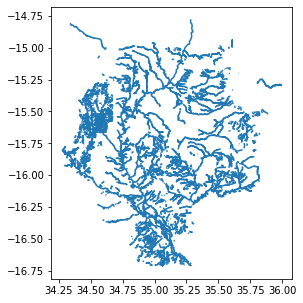

In [8]:
# To reduce memory load, crop global waterways map to only the required area
waterwayscrop = waterways.cx[34.2:35.9, -16.7:-15.0]
waterwayscrop.plot(figsize=(5, 5))
plt.show()

In [16]:
def gdftotif(gdf, file):
    # Takes GeoDataFrame containing vectors and output filename as input and uses the GeoCube package to rasterise,
    # writing the resulting raster to a GeoTIFF file.

    # Add dummy column of ones for every vector to allow plotting. Fill empty space (n/a) with negative ones.
    gdf['points'] = 1
    cube = make_geocube(vector_data=gdf, resolution=(-0.001, 0.001), measurements=['points'], fill=np.nan,
                        ).fillna(-1)
    upsampled = cube.rio.reproject(
        cube.rio.crs, resolution=0.005, resampling=Resampling.average)
    upsampled.points.rio.to_raster(os.path.join('data',file))

gdftotif(waterwayscrop, 'waterways.tif')
gdftotif(wareas, 'wareas.tif')
gdftotif(wlines, 'wlines.tif')

def distancetransform(tif):
    # Accepts GeoTIFF as input. Applies SciPy's distance transform function to 2D NumPY array, and returns the transformed array
    # and metadata saved from GeoTIFF file.
    src = rasterio.open(os.path.join('data',tif))
    meta = src.profile
    array = src.read(1)
    mask = np.clip(array * -1, 0, 1)
    dt = distance_transform_edt(mask)
    return dt, meta

dt1, meta1 = distancetransform('waterways.tif')
dt2, meta2 = distancetransform('wlines.tif')
dt3, meta3 = distancetransform('wareas.tif')

/Users/tom/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Save output
Output saved as GeoTIFFs ready to be read into the main pipeline.

In [17]:
def writetif(file, array, meta):
    # Takes as input a GeoTIFF file, a numpy array of values to write to it, and Geo metadata saved from the old file.
    # Overwrites the TIFF file with the new array of values using the same metadata (coordinates, coordinate system)

    with rasterio.open(os.path.join('data',file), 'w', **meta) as dst:
        dst.write(array, 1)

writetif('dtwaterways.tif', dt1, meta1)
writetif('dtwlines.tif', dt2, meta2)
writetif('dtwareas.tif', dt3, meta3)